In [1]:
from __future__ import print_function
from __future__ import division

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
assert torch.cuda.is_available(), 'GPU unavailable'

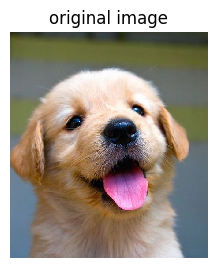

(516, 449, 3)


In [3]:
def error(x, y):
  if type(x) is torch.Tensor:
    x = x.detach().cpu().numpy()
  if type(y) is torch.Tensor:
      y = y.detach().cpu().numpy()    
  return float(np.abs(x - y).max().item())

def display(images, titles=""):
  if type(images) is not list:
    images = [images]
    titles = [titles]
  num = len(images)
  assert len(titles) == num

  plt.figure(figsize=(3*num, 3*num), dpi=100)
  for i in range(num):
    title = titles[i]
    image = images[i]
    plt.subplot(1, num, i+1)
    clip = np.clip(image, 0, 255).astype(np.uint8)
    plt.imshow(clip)
    if len(title) > 0:
      plt.title(title)
    plt.axis('off')
  plt.show()

# read image from url
url = "https://drive.google.com/uc?export=view&id=1IW5HONi0iZoA1gvux_MGXJdnrO8LpJrB"
response = requests.get(url)
rgb_img = Image.open(BytesIO(response.content))
img = np.array(rgb_img).astype("float")
display(img, titles="original image")
print(img.shape)  # H×W×C

**Custom Gaussian Filter**

1d filter

In [4]:
def gaussian_filter_1d(img, k, sigma, horizontal=True):
  """
  img: np.array of image H × W × C, float
  k: 1d kernel size, positive odd int
  sigma: Gaussian standard deviation, positive float
  horizontal: whether it's horizontal or vertical filter; the function should work for both cases
  return: np.array of filterd image H × W × C, float
  """
  assert k > 0 and k % 2 == 1
  filtered = None
  gf = []
  for i in range(k):
    gf.append(math.exp(-1*(i-(k-1)/2)**2/(2*sigma**2)))
  gf = torch.tensor(gf,dtype=torch.float64)
  gf = gf/gf.sum()
  gf = gf.view(1,1,-1)

  #Iterate channel to compute the filtered image
  each_channel = []
  each_cr = []
  if horizontal:
    for i in range(img.shape[2]):
      for j in range(img.shape[0]):
        img_data = torch.from_numpy(img[j,:,i].astype(np.float64)).view(1,1,-1)
        cvlted = F.conv1d(img_data,gf,stride=1,padding="same").squeeze()
        each_cr.append(cvlted.numpy())
      each_channel.append(np.stack(each_cr))
      each_cr = []
  else:
    for i in range(img.shape[2]):
      for j in range(img.shape[1]):
        img_data = torch.from_numpy(img[:,j,i].astype(np.float64)).view(1,1,-1)
        cvlted = F.conv1d(img_data,gf,stride=1,padding="same").squeeze()
        each_cr.append(cvlted.numpy())
      each_channel.append(np.stack(each_cr).transpose())
      each_cr = []
  filtered = np.stack(each_channel, axis=-1)
  # END OF YOUR CODE
  return filtered

In [5]:
def check_gaussian_filter_1d(img, kW, kH, sigmaW=1, sigmaH=1):
  if kH == 1:
    actual = gaussian_filter_1d(img, kW, sigmaW, horizontal=True)
  elif kW == 1:
    actual = gaussian_filter_1d(img, kH, sigmaH, horizontal=False)
  expected = cv2.GaussianBlur(img, ksize=(kW,kH), sigmaX=sigmaW, sigmaY=sigmaH, borderType=cv2.BORDER_CONSTANT)
  assert actual.shape == img.shape
  err = error(actual, expected)
  assert err < 1e-5, f"large error {err: .5f}"
  print(f"pass")

a. No Blur

In [6]:
check_gaussian_filter_1d(img, kW=1, kH=1)

pass


b. Horizontal

In [7]:
check_gaussian_filter_1d(img, kW=13, kH=1, sigmaW=10)

pass


c. Vertical

In [8]:
check_gaussian_filter_1d(img, kW=1, kH=17, sigmaH=21)

pass


2d filter

In [9]:
def gaussian_filter_2d(img, kW, kH, sigmaW=1, sigmaH=1):
  filtered = gaussian_filter_1d(gaussian_filter_1d(img, kW, sigmaW), kH, sigmaH, False)
  return filtered

In [10]:
def check_gaussian_filter_2d(img, kW, kH, sigmaW=1, sigmaH=1):
  actual = gaussian_filter_2d(img, kW, kH, sigmaW, sigmaH)
  expected = cv2.GaussianBlur(img, ksize=(kW,kH), sigmaX=sigmaW, sigmaY=sigmaH, borderType=cv2.BORDER_CONSTANT)
  assert actual.shape == img.shape
  err = error(actual, expected)
  assert err < 1e-4, f"large error {err: .4f}"
  print(f"pass")

In [11]:
check_gaussian_filter_2d(img, kW=1, kH=1, sigmaW=50, sigmaH=29)

pass


In [12]:
check_gaussian_filter_2d(img, kW=21, kH=11, sigmaW=45, sigmaH=30)

pass


**Check**

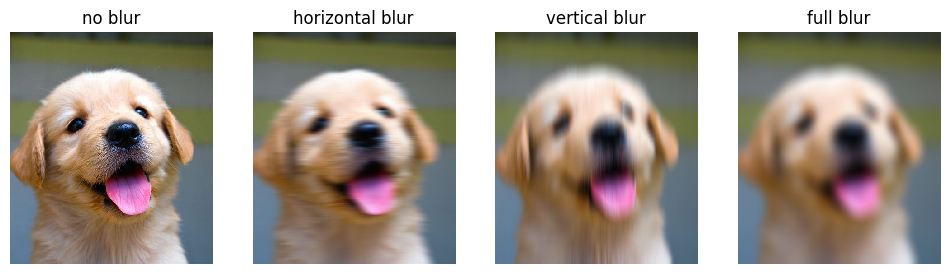

In [13]:
no_blur = cv2.GaussianBlur(img, ksize=(1,1), sigmaX=10, sigmaY=20)
h_blur = cv2.GaussianBlur(img, ksize=(31,1), sigmaX=10, sigmaY=20)
v_blur = cv2.GaussianBlur(img, ksize=(1,41), sigmaX=10, sigmaY=20)
full_blur = cv2.GaussianBlur(img, ksize=(31,41), sigmaX=10, sigmaY=20)
display([no_blur, h_blur, v_blur, full_blur], titles=["no blur", "horizontal blur", "vertical blur", "full blur"])

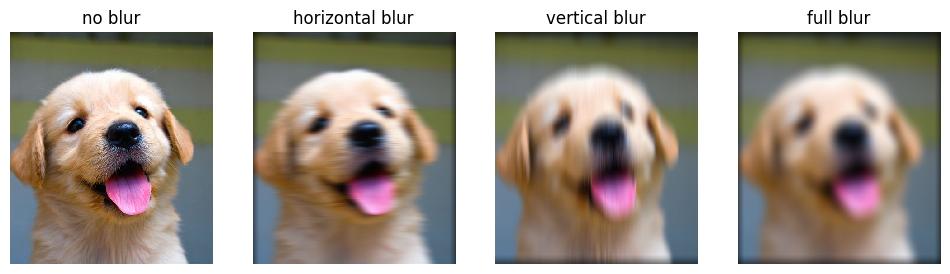

In [15]:
no_blur2 = gaussian_filter_2d(img, 1, 1, sigmaW=10, sigmaH=20)
h_blur2 = gaussian_filter_2d(img, 31, 1, sigmaW=10, sigmaH=20)
v_blur2 = gaussian_filter_2d(img, 1, 41, sigmaW=10, sigmaH=20)
full_blur2 = gaussian_filter_2d(img, 31, 41, sigmaW=10, sigmaH=20)
display([no_blur2, h_blur2, v_blur2, full_blur2], titles=["no blur", "horizontal blur", "vertical blur", "full blur"])